<a href="https://www.kaggle.com/code/yovipi/football-predictor-model-ipynb?scriptVersionId=270368239" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# The Beautiful Game Oracle — Baseline TensorFlow Suite

This notebook prepares and compares three TensorFlow/Keras baseline models for predicting English Premier League match outcomes using data pulled directly from the Understat API. It aligns with the project charter in `README.md` and the agent directives in `AGENTS.md`, emphasising reproducible experiments, attribution readiness, and run tracking for longitudinal comparisons.


## Operating Workflow Alignment
1. **Context Intake** – restate the project objective, active seasons, and dataset label for this run.
2. **Data Audit** – profile coverage, balance, and missingness on the loaded Understat-derived tables.
3. **Structuring Plan** – map the performance, momentum, and market feature views onto consistent TensorFlow `tf.data` scaffolding.
4. **Modeling Setup** – train and evaluate the baseline architectures with shared seeds and logging hooks.
5. **Attribution Hooks** – persist metrics and artefacts for downstream Shapley/LOO diagnostics.
6. **Synthesis & Reporting** – sync the experiment registry and document hypotheses for the next iteration.

## Context Intake
- **Objective:** predict EPL outcomes (`Home Win`, `Draw`, `Away Win`) with parallel performance, momentum, and market signals per the project charter.
- **Data scope:** `Dataset_Version_5` aggregated from Understat, Elo, and implied-odds feeds for seasons 2020–2023 (configurable via `SEASONS`).
- **Operational constraints:** keep Kaggle-friendly paths, reproducible seeds, and logged artefacts for later attribution passes.

## Environment Setup

In [1]:
import sys
import json
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import xgboost as xgb
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = 100

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [2]:
# Ensure repo-level modules (analysis/, etc.) are importable
PROJECT_ROOT_CANDIDATES = [
    Path.cwd(),
    Path.cwd().parent,
    Path.cwd() / "The-Beautiful-Game-Oracle",
]

analysis_root = None
for candidate in PROJECT_ROOT_CANDIDATES:
    if candidate is None:
        continue
    candidate = candidate.resolve()
    if (candidate / "analysis").is_dir():
        analysis_root = candidate
        break

if analysis_root is None:
    analysis_root = Path.cwd().resolve()

if str(analysis_root) not in sys.path:
    sys.path.append(str(analysis_root))


## Experiment Configuration

In [3]:
# Experiment configuration
PROJECT_NAME = "The-Beautiful-Game-Oracle"
LEAGUE = "EPL"
SEASONS = ["2023", "2022", "2021", "2020"]  # extend or adjust as needed
ROLLING_WINDOW = 5
BATCH_SIZE = 64
EPOCHS = 50
REFRESH_DATA = False  # set True to refetch from Understat
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
DATASET_LABEL = "Dataset_Version_5"

DATASET_FILENAME = "Dataset_Version_5.csv"
LEGACY_DATASET_FILENAMES = ["Dataset_Version_3.csv", "Dataset.csv"]

# Filesystem locations (compatible with Kaggle + local use)
LEAGUE_RESULTS_PATH: Path | None = None
candidate_paths: list[Path] = []


def _register_candidate(path: Path) -> None:
    if path not in candidate_paths:
        candidate_paths.append(path)


if Path("/kaggle").exists():
    BASE_WORKING_DIR = Path("/kaggle/working")
    kaggle_input_root = Path("/kaggle/input")
    named_dirs = [
        kaggle_input_root / "dataset-version-4",
        kaggle_input_root / "the-beautiful-game-oracle-datasets",
        kaggle_input_root / "football-predictor-dataset",
        kaggle_input_root / "football-predictor-dataset-v4",
    ]
    for directory in named_dirs:
        _register_candidate(directory / DATASET_FILENAME)
    _register_candidate(kaggle_input_root / DATASET_FILENAME)
    if kaggle_input_root.exists():
        for located_path in kaggle_input_root.glob(f"**/{DATASET_FILENAME}"):
            _register_candidate(located_path)
    for legacy_name in LEGACY_DATASET_FILENAMES:
        _register_candidate(kaggle_input_root / legacy_name)
else:
    BASE_WORKING_DIR = Path("./artifacts")
    data_root = Path("understat_data")
    _register_candidate(data_root / DATASET_FILENAME)
    for legacy_name in LEGACY_DATASET_FILENAMES:
        _register_candidate(data_root / legacy_name)
    _register_candidate(data_root / "league_results_v2.csv")

for candidate in candidate_paths:
    if candidate.exists():
        LEAGUE_RESULTS_PATH = candidate
        break

if LEAGUE_RESULTS_PATH is None or not LEAGUE_RESULTS_PATH.exists():
    raise FileNotFoundError(f"League results CSV missing at any of: {candidate_paths}")

EXPERIMENT_ROOT = BASE_WORKING_DIR / "experiments"
CACHE_DIR = EXPERIMENT_ROOT / "understat_cache"
MODEL_ARTIFACT_DIR = EXPERIMENT_ROOT / f"run_{RUN_ID}"
RUN_LOG_PATH = EXPERIMENT_ROOT / "baseline_run_history.csv"

for path in [EXPERIMENT_ROOT, CACHE_DIR, MODEL_ARTIFACT_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project: {PROJECT_NAME}")
print(f"Seasons loaded: {SEASONS}")
print(f"Working dir: {BASE_WORKING_DIR.resolve()}")
print(f"League results source: {LEAGUE_RESULTS_PATH}")
print(f"Current run artefacts: {MODEL_ARTIFACT_DIR}")
RUN_LOG_COLUMNS = [
    "timestamp",
    "run_id",
    "baseline",
    "trainer",
    "feature_view",
    "train_accuracy",
    "val_accuracy",
    "test_accuracy",
    "train_loss",
    "val_loss",
    "test_loss",
    "val_logloss",
    "test_logloss",
    "epochs_trained",
    "seasons",
    "dataset_label",
    "notes",
]


Project: The-Beautiful-Game-Oracle
Seasons loaded: ['2023', '2022', '2021', '2020']
Working dir: /Users/yohannvinod/Github/The-Beautiful-Game-Oracle/artifacts
League results source: understat_data/Dataset_Version_5.csv
Current run artefacts: artifacts/experiments/run_20251111-025329


### Dataset Label Input
Use the box below to assign a dataset label for this run. This label will be stored with training logs and shown in historical comparisons.

In [4]:
# Interactive dataset label capture
dataset_label_box = widgets.Text(
    value=DATASET_LABEL or "",
    placeholder="e.g., Kaggle Dataset v1",
    description="Dataset:",
    layout=widgets.Layout(width="50%"),
)

dataset_label_status = widgets.HTML()

def _update_dataset_label(change=None):
    global DATASET_LABEL
    label = dataset_label_box.value.strip()
    DATASET_LABEL = label if label else None
    display_value = DATASET_LABEL or "not set"
    dataset_label_status.value = f"<b>Active dataset label:</b> {display_value}"

_update_dataset_label()
dataset_label_box.observe(_update_dataset_label, names="value")
display(widgets.VBox([dataset_label_box, dataset_label_status]))



## Data Audit & Preparation
Load the latest curated Understat-derived dataset, enforce canonical schema, and ready the frame for downstream feature views.

## Feature Engineering Utilities

In [5]:
# Feature engineering utilities
CLASS_LABELS = ["Home Win", "Draw", "Away Win"]


def resolve_outcome_target(df: pd.DataFrame) -> pd.Series:
    """Map dataset outcome signals to canonical CLASS_LABELS ordering."""
    label_to_index = {label: idx for idx, label in enumerate(CLASS_LABELS)}
    if "outcome_id" in df.columns:
        outcome_series = pd.to_numeric(df["outcome_id"], errors="coerce")
        if "match_outcome" in df.columns:
            crosswalk = (
                pd.DataFrame({
                    "outcome_id": outcome_series,
                    "match_outcome": df["match_outcome"],
                })
                .dropna()
                .drop_duplicates()
            )
            if not crosswalk.empty:
                id_to_label = {
                    int(row.outcome_id): row.match_outcome
                    for row in crosswalk.itertuples(index=False)
                    if row.match_outcome in label_to_index
                }
                if id_to_label:
                    remap = {oid: label_to_index[label] for oid, label in id_to_label.items()}
                    mapped = outcome_series.map(remap)
                    if mapped.notna().all():
                        return mapped.astype(int)
        canonical_map = {0: label_to_index["Home Win"], 1: label_to_index["Draw"], 2: label_to_index["Away Win"]}
        mapped = outcome_series.map(canonical_map)
        if mapped.notna().all():
            return mapped.astype(int)
    if "match_outcome_code" in df.columns:
        code_map = {"H": label_to_index["Home Win"], "D": label_to_index["Draw"], "A": label_to_index["Away Win"]}
        return df["match_outcome_code"].map(code_map).astype(int)
    if "match_outcome" in df.columns:
        return df["match_outcome"].map(label_to_index).astype(int)
    raise KeyError("Could not resolve outcome target columns for dataset.")

## Dataset Assembly

In [6]:
# Load and prepare datasets

raw_matches_df = pd.read_csv(
    LEAGUE_RESULTS_PATH,
    parse_dates=["match_datetime_utc", "match_date"],
)
raw_matches_df["is_result"] = raw_matches_df["is_result"].astype(str).str.lower() == "true"

# Filter to completed fixtures for the configured league
league_filtered_df = raw_matches_df.loc[raw_matches_df["league"] == LEAGUE].copy()
match_features_df = (
    league_filtered_df.loc[league_filtered_df["is_result"]]
    .assign(
        season=lambda df: df["season"].astype(str),
        match_date=lambda df: pd.to_datetime(df["match_date"], errors="coerce"),
        home_team=lambda df: df["home_team_name"],
        away_team=lambda df: df["away_team_name"],
        home_prob_win=lambda df: df["forecast_home_win"].astype(float),
        draw_prob=lambda df: df["forecast_draw"].astype(float),
        away_prob_win=lambda df: df["forecast_away_win"].astype(float),
        home_prob_loss=lambda df: df["forecast_away_win"].astype(float),
        away_prob_loss=lambda df: df["forecast_home_win"].astype(float),
        match_draw_prob=lambda df: df["forecast_draw"].astype(float),
        prob_edge=lambda df: df["forecast_home_win"].astype(float) - df["forecast_away_win"].astype(float),
        match_day_index=lambda df: (df["match_date"] - df["match_date"].min()).dt.days.astype(float),
        match_day_of_year=lambda df: df["match_date"].dt.dayofyear.astype(float),
        match_day_of_year_norm=lambda df: df["match_date"].dt.dayofyear.astype(float) / 366.0,
        match_weekday_index=lambda df: df["match_date"].dt.weekday.astype(float),
        match_weekday=lambda df: df["match_weekday"] if "match_weekday" in df else df["match_date"].dt.day_name(),
        target=lambda df: resolve_outcome_target(df),
    )
    .sort_values("match_datetime_utc")
    .reset_index(drop=True)
)

weekday_cols = []

numeric_prefixes = (
    "home_",
    "away_",
    "form_",
    "market_",
    "rest_",
    "season_phase",
    "xg_",
    "forecast_",
    "goal_",
    "total_",
    "prob_",
    "match_",
    "momentum_",
    "elo_",
    "shot_",
    "shots_",
)
non_numeric_feature_columns = {
    "home_team",
    "away_team",
    "home_team_name",
    "away_team_name",
    "home_team_short",
    "away_team_short",
    "match_datetime_utc",
    "match_date",
    "match_time",
    "match_weekday",
    "match_outcome",
    "match_outcome_code",
}
prefixed_cols = [
    col
    for col in match_features_df.columns
    if col.startswith(numeric_prefixes) and col not in non_numeric_feature_columns
]
match_features_df[prefixed_cols] = match_features_df[prefixed_cols].apply(pd.to_numeric, errors="coerce")


def _prior_rolling_mean(df: pd.DataFrame, team_col: str, value_col: str, window: int) -> pd.Series:
    series = (
        df.groupby(team_col, sort=False)[value_col]
        .transform(lambda s: s.rolling(window, min_periods=1).mean().shift(1))
    )
    fallback = df.groupby(team_col, sort=False)[value_col].transform(lambda s: s.shift(1))
    median = df[value_col].median(skipna=True)
    return series.fillna(fallback).fillna(median if pd.notna(median) else 0.0).astype(np.float32)


def _season_zscore(df: pd.DataFrame, column: str) -> pd.Series:
    grouped = df.groupby("season")[column]
    mean = grouped.transform("mean")
    std = grouped.transform("std").replace(0.0, np.nan)
    z = (df[column] - mean) / std
    return z.replace([np.inf, -np.inf], 0.0).fillna(0.0).astype(np.float32)


# Elo-derived strength features
elo_cols = ["elo_home_pre", "elo_away_pre", "elo_home_expectation"]
for col in elo_cols:
    if col in match_features_df.columns:
        match_features_df[col] = pd.to_numeric(match_features_df[col], errors="coerce")
        if match_features_df[col].notna().any():
            match_features_df[col] = match_features_df[col].fillna(match_features_df[col].median())
        else:
            match_features_df[col] = match_features_df[col].fillna(0.0)

if {"elo_home_pre", "elo_away_pre"}.issubset(match_features_df.columns):
    match_features_df["elo_mean_pre"] = (
        match_features_df["elo_home_pre"] + match_features_df["elo_away_pre"]
    ) / 2.0
    match_features_df["elo_gap_pre"] = match_features_df["elo_home_pre"] - match_features_df["elo_away_pre"]
    match_features_df["elo_gap_pre_season_z"] = _season_zscore(match_features_df, "elo_gap_pre")

if "elo_home_expectation" in match_features_df.columns:
    match_features_df["elo_away_expectation"] = 1.0 - match_features_df["elo_home_expectation"]
    match_features_df["elo_expectation_gap"] = match_features_df["elo_home_expectation"] - match_features_df["elo_away_expectation"]
else:
    match_features_df["elo_home_expectation"] = 0.5
    match_features_df["elo_away_expectation"] = 0.5
    match_features_df["elo_expectation_gap"] = 0.0

match_features_df["market_vs_elo_edge"] = (
    match_features_df.get("forecast_home_win", 0.0).astype(float)
    - match_features_df.get("elo_home_expectation", 0.5).astype(float)
).clip(-0.35, 0.35).astype(np.float32)

# Elo summary aggregates (season-level strength markers)
summary_numeric_cols = [
    "home_elo_final",
    "away_elo_final",
    "home_elo_matches_played",
    "away_elo_matches_played",
    "home_elo_wins",
    "home_elo_draws",
    "home_elo_losses",
    "away_elo_wins",
    "away_elo_draws",
    "away_elo_losses",
    "home_elo_points_pct",
    "away_elo_points_pct",
]
for col in summary_numeric_cols:
    if col in match_features_df.columns:
        match_features_df[col] = pd.to_numeric(match_features_df[col], errors="coerce").fillna(0.0).astype(np.float32)

if {"home_elo_final", "away_elo_final"}.issubset(match_features_df.columns):
    match_features_df["elo_final_gap"] = (
        match_features_df["home_elo_final"] - match_features_df["away_elo_final"]
    ).astype(np.float32)
    match_features_df["elo_final_mean"] = (
        (match_features_df["home_elo_final"] + match_features_df["away_elo_final"]) / 2.0
    ).astype(np.float32)
    match_features_df["elo_final_gap_season_z"] = _season_zscore(match_features_df, "elo_final_gap")

if {"home_elo_points_pct", "away_elo_points_pct"}.issubset(match_features_df.columns):
    match_features_df["elo_points_pct_gap"] = (
        match_features_df["home_elo_points_pct"] - match_features_df["away_elo_points_pct"]
    ).astype(np.float32)
    match_features_df["elo_points_pct_mean"] = (
        (match_features_df["home_elo_points_pct"] + match_features_df["away_elo_points_pct"]) / 2.0
    ).astype(np.float32)
    match_features_df["elo_points_pct_gap_season_z"] = _season_zscore(match_features_df, "elo_points_pct_gap")

if {"home_elo_matches_played", "away_elo_matches_played"}.issubset(match_features_df.columns):
    match_features_df["elo_experience_gap"] = (
        match_features_df["home_elo_matches_played"] - match_features_df["away_elo_matches_played"]
    ).astype(np.float32)

if {"home_elo_wins", "home_elo_losses", "away_elo_wins", "away_elo_losses"}.issubset(match_features_df.columns):
    home_record_delta = match_features_df["home_elo_wins"] - match_features_df["home_elo_losses"]
    away_record_delta = match_features_df["away_elo_wins"] - match_features_df["away_elo_losses"]
    match_features_df["elo_record_delta"] = (home_record_delta - away_record_delta).astype(np.float32)

# Shot volume and suppression trends
if {"home_shots_for", "away_shots_for"}.issubset(match_features_df.columns):
    for col in ["home_shots_for", "away_shots_for"]:
        match_features_df[col] = pd.to_numeric(match_features_df[col], errors="coerce")
        if match_features_df[col].notna().any():
            match_features_df[col] = match_features_df[col].fillna(match_features_df[col].median())
        else:
            match_features_df[col] = match_features_df[col].fillna(0.0)

    match_features_df["home_shots_allowed"] = match_features_df["away_shots_for"]
    match_features_df["away_shots_allowed"] = match_features_df["home_shots_for"]

    match_features_df["home_shots_for_avg5"] = _prior_rolling_mean(match_features_df, "home_team", "home_shots_for", ROLLING_WINDOW)
    match_features_df["away_shots_for_avg5"] = _prior_rolling_mean(match_features_df, "away_team", "away_shots_for", ROLLING_WINDOW)
    match_features_df["home_shots_allowed_avg5"] = _prior_rolling_mean(match_features_df, "home_team", "home_shots_allowed", ROLLING_WINDOW)
    match_features_df["away_shots_allowed_avg5"] = _prior_rolling_mean(match_features_df, "away_team", "away_shots_allowed", ROLLING_WINDOW)

    short_window = min(3, ROLLING_WINDOW)
    match_features_df["home_shots_for_avg3"] = _prior_rolling_mean(match_features_df, "home_team", "home_shots_for", short_window)
    match_features_df["away_shots_for_avg3"] = _prior_rolling_mean(match_features_df, "away_team", "away_shots_for", short_window)
    match_features_df["home_shots_allowed_avg3"] = _prior_rolling_mean(match_features_df, "home_team", "home_shots_allowed", short_window)
    match_features_df["away_shots_allowed_avg3"] = _prior_rolling_mean(match_features_df, "away_team", "away_shots_allowed", short_window)

    match_features_df["shot_vol_gap_avg5"] = match_features_df["home_shots_for_avg5"] - match_features_df["away_shots_for_avg5"]
    match_features_df["shot_suppress_gap_avg5"] = match_features_df["away_shots_allowed_avg5"] - match_features_df["home_shots_allowed_avg5"]
    match_features_df["log_shot_ratio_avg5"] = np.log(
        (match_features_df["home_shots_for_avg5"] + 1e-3)
        / (match_features_df["away_shots_for_avg5"] + 1e-3)
    )
    match_features_df["shots_tempo_avg5"] = (
        match_features_df["home_shots_for_avg5"] + match_features_df["away_shots_for_avg5"]
    ) / 2.0

    match_features_df["shot_volume_gap_avg3"] = match_features_df["home_shots_for_avg3"] - match_features_df["away_shots_for_avg3"]
    match_features_df["shot_suppress_gap_avg3"] = match_features_df["away_shots_allowed_avg3"] - match_features_df["home_shots_allowed_avg3"]
    match_features_df["shots_tempo_avg3"] = (
        match_features_df["home_shots_for_avg3"] + match_features_df["away_shots_for_avg3"]
    ) / 2.0

    match_features_df["shot_volume_gap_avg3_season_z"] = _season_zscore(match_features_df, "shot_volume_gap_avg3")
    match_features_df["shot_suppress_gap_avg3_season_z"] = _season_zscore(match_features_df, "shot_suppress_gap_avg3")
    match_features_df["shots_tempo_avg3_season_z"] = _season_zscore(match_features_df, "shots_tempo_avg3")

    shot_cols_to_clean = [
        "home_shots_for_avg5",
        "away_shots_for_avg5",
        "home_shots_allowed_avg5",
        "away_shots_allowed_avg5",
        "home_shots_for_avg3",
        "away_shots_for_avg3",
        "home_shots_allowed_avg3",
        "away_shots_allowed_avg3",
        "shot_vol_gap_avg5",
        "shot_suppress_gap_avg5",
        "shot_volume_gap_avg3",
        "shot_suppress_gap_avg3",
        "shots_tempo_avg5",
        "shots_tempo_avg3",
    ]
    for col in shot_cols_to_clean:
        match_features_df[col] = match_features_df[col].astype(np.float32).fillna(0.0)

    match_features_df["log_shot_ratio_avg5"] = (
        match_features_df["log_shot_ratio_avg5"].replace([np.inf, -np.inf], 0.0).fillna(0.0).astype(np.float32)
    )
else:
    match_features_df["log_shot_ratio_avg5"] = 0.0

print(
    f"Prepared {len(match_features_df)} completed fixtures from {LEAGUE_RESULTS_PATH.name} spanning seasons {sorted(match_features_df['season'].unique())} for league {LEAGUE}"
)

display(match_features_df.head())


Prepared 1140 completed fixtures from Dataset_Version_5.csv spanning seasons ['2022', '2023', '2024'] for league EPL


/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/2429732421.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_features_df["elo_away_expectation"] = 1.0 - match_features_df["elo_home_expectation"]
/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/2429732421.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_features_df["elo_final_gap"] = (
/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/2429732421.py:149: PerformanceWarning: DataFrame is highly fragmented.  This i

,match_id,league,season,match_datetime_utc,match_date,match_weekday,home_team_id,home_team_name,away_team_id,away_team_name,home_goals,away_goals,total_goals,goal_difference,home_xg,away_xg,xg_difference,match_outcome,match_outcome_code,outcome_label,outcome_id,home_win_flag,draw_flag,away_win_flag,home_points_actual,away_points_actual,forecast_home_win,forecast_draw,forecast_away_win,market_home_edge,market_expected_points_home,market_expected_points_away,market_entropy,market_logit_home,market_max_prob,away_goal_diff_last_5,away_goals_against_last_5,away_goals_for_last_5,away_points_last_5,away_xg_against_last_5,away_xg_diff_last_5,away_xg_for_last_5,form_diff_last5,form_diff_last5_season_mean,form_diff_last5_season_std,form_diff_last5_season_var,form_diff_last5_season_z,form_pct_diff_last5,form_pct_diff_last5_season_mean,form_pct_diff_last5_season_std,...,away_elo_matches_played,away_elo_wins,away_elo_draws,away_elo_losses,away_elo_points_pct,elo_gap_pre,elo_expectation_gap,elo_gap_pre_season_z,elo_expectation_gap_season_z,market_vs_elo_edge,home_team,away_team,home_prob_win,draw_prob,away_prob_win,home_prob_loss,away_prob_loss,match_draw_prob,prob_edge,match_day_of_year,target,elo_away_expectation,elo_final_gap,elo_final_mean,elo_final_gap_season_z,elo_points_pct_gap,elo_points_pct_mean,elo_points_pct_gap_season_z,elo_experience_gap,elo_record_delta,home_shots_allowed,away_shots_allowed,home_shots_for_avg5,away_shots_for_avg5,home_shots_allowed_avg5,away_shots_allowed_avg5,home_shots_for_avg3,away_shots_for_avg3,home_shots_allowed_avg3,away_shots_allowed_avg3,shot_vol_gap_avg5,shot_suppress_gap_avg5,log_shot_ratio_avg5,shots_tempo_avg5,shot_volume_gap_avg3,shot_suppress_gap_avg3,shots_tempo_avg3,shot_volume_gap_avg3_season_z,shot_suppress_gap_avg3_season_z,shots_tempo_avg3_season_z
0,18202,EPL,2022,2022-08-05 19:00:00,2022-08-05,Friday,78,Crystal Palace,83,Arsenal,0,2,2,-2,1.206370,1.436010,-0.229640,Away Win,A,A,0,0,0,1,0,3,0.2864,0.2912,0.4224,-0.1360,1.1504,1.5584,1.081397,-0.388563,0.4224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.234211,4.837233,23.398829,0.048418,0.0,-0.018553,0.339625,...,125.0,82.0,27.0,16.0,0.7280,0.002,0.1526,-0.003715,-0.0043,-0.2899,Crystal Palace,Arsenal,0.2864,0.2912,0.4224,0.4224,0.2864,0.2912,-0.1360,217.0,2,0.4237,-84.329956,1588.044922,-0.943853,-0.2898,0.58310,-1.402169,-1.0,-68.0,10,11,14.0,11.0,11.0,14.0,14.0,11.0,11.0,14.0,3.0,3.0,0.241143,12.5,3.0,3.0,12.5,0.079678,0.090844,-0.065995
1,18203,EPL,2022,2022-08-06 11:30:00,2022-08-06,Saturday,228,Fulham,87,Liverpool,2,2,4,0,1.268220,2.341110,-1.072890,Draw,D,D,1,0,1,0,1,1,0.1225,0.2133,0.6642,-0.5417,0.5808,2.2059,0.858539,-1.690472,0.6642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.234211,4.837233,23.398829,0.048418,0.0,-0.018553,0.339625,...,124.0,74.0,29.0,21.0,0.6747,0.006,0.1526,-0.003143,-0.0043,-0.3500,Fulham,Liverpool,0.1225,0.2133,0.6642,0.6642,0.1225,0.2133,-0.5417,218.0,1,0.4237,-114.229980,1529.574951,-1.278505,-0.2374,0.55600,-1.148636,1.0,-60.0,11,9,14.0,11.0,11.0,14.0,14.0,11.0,11.0,14.0,3.0,3.0,0.241143,12.5,3.0,3.0,12.5,0.079678,0.090844,-0.065995
2,18204,EPL,2022,2022-08-06 14:00:00,2022-08-06,Saturday,73,Bournemouth,71,Aston Villa,2,0,2,2,0.588341,0.488895,0.099446,Home Win,H,H,2,1,0,0,3,0,0.3213,0.4397,0.2390,0.0823,1.4036,1.1567,1.068161,0.295912,0.4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.234211,4.837233,23.398829,0.048418,0.0,-0.018553,0.339625,...,124.0,61.0,27.0,36.0,0.5645,-0.010,0.1526,-0.005430,-0.0043,-0.2550,Bournemouth,Aston Villa,0.3213,0.4397,0.2390,0.2390,0.3213,0.4397,0.0823,218.0,0,0.4237,-1.489990,1534.505005,-0.016677,-0.1317,0.49865,-0.637217,0.0,-32.0,15,7,14.0,11.0,11.0,14.0,14.0,11.0,11.0,14.0,3.0,3.0,0.241143,12.5,3.0,3.0,12.5,0.079678,0.090844,-0.065995
3,18205,EPL,2022,2022-08-06 14:00:00,2022-08-06,Saturday,245,Leeds,229,Wolverhampton Wanderers,2,1,3,1,0.889170,1.101190,-0.212020,Home Win,H,H,2,1,0,0,3,0,0.2798,0.3166,0.4036,-0.1238,1.1560,1.5274,1.086701,-0.366349,0.4036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.234

### Data Quality Snapshot
Capture quick coverage diagnostics (per-season class balance and top missing ratios) before training.

In [7]:
# Coverage diagnostics documented for this run
outcome_labels = dict(enumerate(CLASS_LABELS))
season_outcome = (
    match_features_df.assign(outcome_label=match_features_df["target"].map(outcome_labels))
    .groupby(["season", "outcome_label"])
    .size()
    .unstack(fill_value=0)
    .astype(int)
)
season_outcome = season_outcome.reindex(sorted(season_outcome.index), axis=0)
print("Matches per season/outcome:")
display(season_outcome)

target_share = (
    match_features_df["target"]
    .value_counts(normalize=True)
    .rename_axis("target")
    .rename("share")
    .mul(100)
    .round(2)
)
print("Target distribution (% of matches):")
display(target_share.to_frame())

missing_pct = (
    match_features_df.isna().mean().mul(100).sort_values(ascending=False).head(10)
    .rename("missing_pct")
)
print("Top columns by missing percentage:")
display(missing_pct.to_frame())

Matches per season/outcome:


outcome_label,Away Win,Draw,Home Win
season,,,
2022,109,87,184
2023,123,82,175
2024,132,93,155


Target distribution (% of matches):


,share
target,
0,45.09
2,31.93
1,22.98


Top columns by missing percentage:


,missing_pct
match_id,0.0
rest_diff_season_mean,0.0
rest_diff_season_var,0.0
rest_diff_season_z,0.0
rest_reset_flag_pair,0.0
xg_diff_last5,0.0
is_result,0.0
fixture_congestion_flag_pair,0.0
match_day_index,0.0
match_day_of_year_norm,0.0


## Train/Validation/Test Split

In [8]:

# Chronological train/validation/test split
sorted_df = match_features_df.sort_values("match_date").reset_index(drop=True)
num_matches = len(sorted_df)
train_end = int(num_matches * 0.6)
val_end = int(num_matches * 0.8)

split_indices = {
    "train": sorted_df.index[:train_end],
    "val": sorted_df.index[train_end:val_end],
    "test": sorted_df.index[val_end:],
}

print({k: len(v) for k, v in split_indices.items()})


{'train': 684, 'val': 228, 'test': 228}


## Structuring Plan — Feature Views
Three complementary feature views keep the performance (dense), momentum (policy/RL), and market (gradient boosting) signals aligned with shared splits and preprocessing.

In [9]:
# Feature view utilities

from abc import ABC, abstractmethod


def select_features(df: pd.DataFrame, candidates: list[str]) -> list[str]:
    """Return candidate columns present in the dataframe, preserving order."""
    return [col for col in candidates if col in df.columns]


def unique(seq: list[str]) -> list[str]:
    """Deduplicate while preserving order."""
    seen: set[str] = set()
    ordered: list[str] = []
    for item in seq:
        if item not in seen:
            seen.add(item)
            ordered.append(item)
    return ordered


class BaseFeatureView(ABC):
    """Base class for feature view preparation and specs."""

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self._feature_cols: list[str] | None = None

    @abstractmethod
    def prepare(self) -> None:
        """Mutate underlying dataframe with view-specific engineering."""
        raise NotImplementedError

    @abstractmethod
    def feature_columns(self) -> list[str]:
        raise NotImplementedError

    def include_market_probs(self) -> bool:
        return False

    def scale_strategy(self) -> str | None:
        return None

    def build_spec(self, *, description: str, trainer: str, **extra: object) -> dict[str, object]:
        spec: dict[str, object] = {
            "description": description,
            "feature_cols": self.feature_columns(),
            "trainer": trainer,
            **extra,
        }
        scale = self.scale_strategy()
        if scale:
            spec.setdefault("scale_strategy", scale)
        if self.include_market_probs():
            spec.setdefault("include_market_probs", True)
        return spec


## Performance Data View

In [10]:
# Performance data view

class PerformanceFeatureView(BaseFeatureView):
    """Smoothed per-match aggregates tailored for the dense baseline."""

    EPS = 1e-3

    def __init__(self, df: pd.DataFrame, rolling_window: int) -> None:
        super().__init__(df)
        self.rolling_window = rolling_window

    @staticmethod
    def _smoothed_avg(sum_series: pd.Series, games_frac: pd.Series, window: int) -> pd.Series:
        games = games_frac * window
        per_match = sum_series / games.replace(0.0, np.nan)
        prior = per_match.dropna().mean()
        prior = 0.0 if np.isnan(prior) else prior
        per_match = per_match.fillna(prior)
        alpha = games_frac.clip(0.0, 1.0)
        return (alpha * per_match + (1.0 - alpha) * prior).astype(np.float32)

    def prepare(self) -> None:
        df = self.df
        window = self.rolling_window

        if "home_goals_for_avg5" not in df.columns:
            home_games = df.groupby(["season", "home_team"], sort=False).cumcount().clip(upper=window).astype(float)
            away_games = df.groupby(["season", "away_team"], sort=False).cumcount().clip(upper=window).astype(float)

            df["home_recent_games_frac"] = (home_games / window).astype(np.float32)
            df["away_recent_games_frac"] = (away_games / window).astype(np.float32)

            df["home_goals_for_avg5"] = self._smoothed_avg(df["home_goals_for_last_5"], df["home_recent_games_frac"], window)
            df["home_goals_against_avg5"] = self._smoothed_avg(df["home_goals_against_last_5"], df["home_recent_games_frac"], window)
            df["home_xg_for_avg5"] = self._smoothed_avg(df["home_xg_for_last_5"], df["home_recent_games_frac"], window)
            df["home_xg_against_avg5"] = self._smoothed_avg(df["home_xg_against_last_5"], df["home_recent_games_frac"], window)
            df["home_points_avg5"] = self._smoothed_avg(df["home_points_last_5"], df["home_recent_games_frac"], window)

            df["away_goals_for_avg5"] = self._smoothed_avg(df["away_goals_for_last_5"], df["away_recent_games_frac"], window)
            df["away_goals_against_avg5"] = self._smoothed_avg(df["away_goals_against_last_5"], df["away_recent_games_frac"], window)
            df["away_xg_for_avg5"] = self._smoothed_avg(df["away_xg_for_last_5"], df["away_recent_games_frac"], window)
            df["away_xg_against_avg5"] = self._smoothed_avg(df["away_xg_against_last_5"], df["away_recent_games_frac"], window)
            df["away_points_avg5"] = self._smoothed_avg(df["away_points_last_5"], df["away_recent_games_frac"], window)

            df["att_gap_avg5"] = df["home_goals_for_avg5"] - df["away_goals_for_avg5"]
            df["def_gap_avg5"] = df["away_goals_against_avg5"] - df["home_goals_against_avg5"]
            df["points_gap_avg5"] = df["home_points_avg5"] - df["away_points_avg5"]
            df["xg_att_gap_avg5"] = df["home_xg_for_avg5"] - df["away_xg_for_avg5"]
            df["xg_def_gap_avg5"] = df["away_xg_against_avg5"] - df["home_xg_against_avg5"]

            df["log_goal_ratio_avg5"] = np.log((df["home_goals_for_avg5"] + self.EPS) / (df["away_goals_for_avg5"] + self.EPS))
            df["log_points_ratio_avg5"] = np.log((df["home_points_avg5"] + self.EPS) / (df["away_points_avg5"] + self.EPS))
            df["log_xg_ratio_avg5"] = np.log((df["home_xg_for_avg5"] + self.EPS) / (df["away_xg_for_avg5"] + self.EPS))


        if "log_shot_ratio_avg5" not in df.columns and {"home_shots_for_avg5", "away_shots_for_avg5"}.issubset(df.columns):
            df["log_shot_ratio_avg5"] = np.log(
                (df["home_shots_for_avg5"] + self.EPS)
                / (df["away_shots_for_avg5"] + self.EPS)
            )

        ratio_cols = [col for col in [
            "log_goal_ratio_avg5",
            "log_points_ratio_avg5",
            "log_xg_ratio_avg5",
            "log_shot_ratio_avg5",
        ] if col in df.columns]
        if ratio_cols:
            df[ratio_cols] = (
                df[ratio_cols]
                .replace([np.inf, -np.inf], 0.0)
                .fillna(0.0)
                .astype(np.float32)
            )

    def feature_columns(self) -> list[str]:
        if self._feature_cols is None:
            self.prepare()
            columns = [
                "home_recent_games_frac",
                "away_recent_games_frac",
                "home_shots_for_avg5",
                "home_shots_allowed_avg5",
                "away_shots_for_avg5",
                "away_shots_allowed_avg5",
                "shot_vol_gap_avg5",
                "shot_suppress_gap_avg5",
                "log_shot_ratio_avg5",
                "shots_tempo_avg5",
                "att_gap_avg5",
                "def_gap_avg5",
                "points_gap_avg5",
                "xg_att_gap_avg5",
                "xg_def_gap_avg5",
                "log_xg_ratio_avg5",
                "home_goals_for_avg5",
                "home_goals_against_avg5",
                "away_goals_for_avg5",
                "away_goals_against_avg5",
                "elo_home_pre",
                "elo_away_pre",
                "elo_mean_pre",
                "elo_gap_pre",
                "elo_home_expectation",
                "elo_expectation_gap",
                "market_vs_elo_edge",
            ]
            self._feature_cols = unique(select_features(self.df, columns))
        return self._feature_cols

    def scale_strategy(self) -> str | None:
        return "zscore"


## Momentum data view

In [11]:


class MomentumFeatureView(BaseFeatureView):
    def __init__(self, df: pd.DataFrame, weekday_columns: list[str]) -> None:
        super().__init__(df)
        self.weekday_columns = weekday_columns

    def prepare(self) -> None:
        # Momentum features already materialised during dataset build.
        return

    def feature_columns(self) -> list[str]:
        if self._feature_cols is None:
            base_columns = [
                "momentum_points_last3_delta_season_z",
                "momentum_points_last2_delta_season_z",
                "momentum_points_last8_delta_season_z",
                "momentum_points_pct_last3_delta_season_z",
                "momentum_goal_diff_last3_delta_season_z",
                "momentum_goal_diff_last2_delta_season_z",
                "momentum_goal_diff_last8_delta_season_z",
                "momentum_xg_diff_last3_delta_season_z",
                "momentum_xg_diff_last2_delta_season_z",
                "momentum_xg_diff_last8_delta_season_z",
                "momentum_points_exp_decay_delta_season_z",
                "momentum_xg_exp_decay_delta_season_z",
                "momentum_matches_last14_delta_season_z",
                "momentum_travel_rest_ratio_delta_season_z",
                "momentum_forecast_win_prev_delta_season_z",
                "momentum_forecast_trend_delta_season_z",
                "shot_volume_gap_avg3_season_z",
                "shot_suppress_gap_avg3_season_z",
                "shots_tempo_avg3_season_z",
                "elo_gap_pre_season_z",
                "market_vs_elo_edge",
                "form_pct_diff_last5_season_z",
                "form_diff_last5_season_z",
                "rest_diff_season_z",
                "fixture_congestion_flag_pair",
                "momentum_fixture_congestion_delta",
                "rest_reset_flag_pair",
                "match_day_index_season_z",
                "match_day_of_year_norm_season_z",
                "match_weekday_index_season_z",
            ]
            columns = base_columns + self.weekday_columns
            self._feature_cols = unique(select_features(self.df, columns))
        return self._feature_cols

    def include_market_probs(self) -> bool:
        return True


## Market data view

In [12]:
# Market data view

class MarketFeatureView(BaseFeatureView):
    def __init__(self, df: pd.DataFrame, weekday_columns: list[str]) -> None:
        super().__init__(df)
        self.weekday_columns = weekday_columns

    def prepare(self) -> None:
        return

    def feature_columns(self) -> list[str]:
        if self._feature_cols is None:
            base_columns = [
                "forecast_home_win",
                "forecast_draw",
                "forecast_away_win",
                "market_home_edge",
                "market_entropy",
                "market_logit_home",
                "market_max_prob",
                "prob_edge",
                "elo_home_pre",
                "elo_away_pre",
                "elo_mean_pre",
                "elo_gap_pre",
                "elo_home_expectation",
                "elo_expectation_gap",
                "market_vs_elo_edge",
                "match_day_index",
                "match_day_of_year_norm",
                "match_weekday_index",
            ]
            columns = base_columns + self.weekday_columns
            self._feature_cols = unique(select_features(self.df, columns))
        return self._feature_cols


In [13]:
# Feature set registry built from view builders

performance_view = PerformanceFeatureView(match_features_df, ROLLING_WINDOW)
PERFORMANCE_FEATURES = performance_view.feature_columns()

momentum_view = MomentumFeatureView(match_features_df, weekday_cols)
MOMENTUM_FEATURES = momentum_view.feature_columns()

market_view = MarketFeatureView(match_features_df, weekday_cols)
MARKET_FEATURES = market_view.feature_columns()

FEATURE_SETS = {
    "performance_dense": performance_view.build_spec(
        description="Performance-based dense network using smoothed per-match aggregates",
        trainer="keras",
        builder_name="build_performance_model",
    ),
    "momentum_policy_rl": momentum_view.build_spec(
        description="Momentum-policy REINFORCE agent leveraging short-horizon trends",
        trainer="reinforce",
        policy_hidden_units=[128, 64],
        gamma=0.95,
        learning_rate=7e-4,
        policy_epochs=max(EPOCHS, 60),
        reward_config={
            "draw_correct_bonus": 0.85,
            "market_upset_bonus": 0.9,
            "market_underdog_threshold": 0.35,
        },
    ),
    "market_gradient_boost": market_view.build_spec(
        description="Market odds derived statistics",
        trainer="xgboost",
        xgb_params={
            "objective": "multi:softprob",
            "learning_rate": 0.05,
            "max_depth": 4,
            "subsample": 0.85,
            "colsample_bytree": 0.75,
            "reg_lambda": 1.0,
            "n_estimators": 600,
            "min_child_weight": 2,
            "random_state": SEED,
            "eval_metric": "mlogloss",
            "tree_method": "hist",
        },
    ),
}

print({name: len(spec["feature_cols"]) for name, spec in FEATURE_SETS.items()})


{'performance_dense': 27, 'momentum_policy_rl': 30, 'market_gradient_boost': 18}


/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/1800852411.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["home_recent_games_frac"] = (home_games / window).astype(np.float32)
/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/1800852411.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["away_recent_games_frac"] = (away_games / window).astype(np.float32)
/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/1800852411.py:33: PerformanceWarning: DataFrame is highly fragmente

## TensorFlow Dataset Utilities

In [14]:
# Dataset constructors

MARKET_PROBABILITY_COLUMNS = ["forecast_home_win", "forecast_draw", "forecast_away_win"]


def prepare_view_frame(df: pd.DataFrame, feature_cols: list[str], *, include_market_probs: bool = False) -> pd.DataFrame:
    base_cols = ["match_id", "season", "match_date", "target"]
    market_cols = MARKET_PROBABILITY_COLUMNS if include_market_probs else []
    ordered_cols = unique(base_cols + feature_cols + market_cols)

    available_cols = [col for col in ordered_cols if col in df.columns]
    view = df.loc[:, available_cols].copy()

    missing_cols = [col for col in ordered_cols if col not in available_cols]
    if missing_cols:
        augment = match_features_df.loc[:, ["match_id", *missing_cols]].drop_duplicates("match_id")
        view = view.merge(augment, on="match_id", how="left")

    numeric_cols = [col for col in ordered_cols if col not in {"match_id", "season", "match_date"}]
    view[numeric_cols] = view[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

    return view.reindex(columns=ordered_cols)


def prepare_feature_matrices(
    df: pd.DataFrame,
    feature_cols: list[str],
    split_indices: dict[str, pd.Index],
    *,
    scale_strategy: str | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return train/val/test feature matrices with optional scaling."""
    matrices = {
        split: df.loc[split_indices[split], feature_cols].astype(np.float32).to_numpy(copy=True)
        for split in ("train", "val", "test")
    }
    if scale_strategy == "zscore":
        train_matrix = matrices["train"]
        mean = train_matrix.mean(axis=0, keepdims=True)
        std = train_matrix.std(axis=0, keepdims=True)
        std = np.where(std < 1e-6, 1.0, std)
        matrices = {split: (mat - mean) / std for split, mat in matrices.items()}
    return matrices["train"], matrices["val"], matrices["test"]


def build_xy(df: pd.DataFrame, feature_cols: list[str], indices: pd.Index) -> tuple[np.ndarray, np.ndarray]:
    X = df.loc[indices, feature_cols].astype(np.float32).to_numpy()
    y = df.loc[indices, "target"].astype(np.int32).to_numpy()
    return X, y


def make_dataset(X: np.ndarray, y: np.ndarray, *, training: bool) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


def compute_class_weights(y: np.ndarray) -> dict[int, float]:
    counts = np.bincount(y, minlength=len(CLASS_LABELS))
    total = float(len(y))
    weights = {cls: total / (len(CLASS_LABELS) * count) for cls, count in enumerate(counts) if count > 0}
    return weights


## Modeling Setup — Baseline Builders

### Performance Dense Baseline

In [15]:
def build_performance_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="performance_features")
    x = keras.layers.Dense(64, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dropout(0.15)(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="performance_dense")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


### Momentum Interaction Baseline

In [16]:
def build_policy_network(input_dim: int, hidden_units: list[int]) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="policy_state")
    x = inputs
    for units in hidden_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.LayerNormalization()(x)
        x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    return keras.Model(inputs, outputs, name="momentum_policy")


def discount_returns(rewards: tf.Tensor, gamma: float) -> tf.Tensor:
    rewards_np = rewards.numpy() if isinstance(rewards, tf.Tensor) else np.asarray(rewards, dtype=np.float32)
    discounted = np.zeros_like(rewards_np, dtype=np.float32)
    running = 0.0
    for t in range(len(rewards_np) - 1, -1, -1):
        running = rewards_np[t] + gamma * running
        discounted[t] = running
    if discounted.std() > 1e-6:
        discounted = (discounted - discounted.mean()) / (discounted.std() + 1e-6)
    else:
        discounted = discounted - discounted.mean()
    return tf.convert_to_tensor(discounted, dtype=tf.float32)


class PolicyGradientAgent:
    """Simple REINFORCE agent for sequential match prediction with reward shaping."""

    def __init__(
        self,
        input_dim: int,
        *,
        hidden_units: list[int],
        learning_rate: float,
        gamma: float,
        reward_config: dict[str, float] | None = None,
    ) -> None:
        self.model = build_policy_network(input_dim, hidden_units)
        self.optimizer = keras.optimizers.Adam(learning_rate)
        self.gamma = gamma
        self.reward_config = {
            "draw_correct_bonus": 0.75,
            "market_upset_bonus": 0.8,
            "market_underdog_threshold": 0.35,
        }
        if reward_config is not None:
            self.reward_config.update(reward_config)
        self.draw_index = CLASS_LABELS.index("Draw")

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict(X, verbose=0)

    def _compute_step_rewards(
        self,
        sampled_actions: tf.Tensor,
        actions_tf: tf.Tensor,
        market_probs: tf.Tensor | None,
    ) -> tf.Tensor:
        correct_mask = tf.equal(sampled_actions, actions_tf)
        reward = tf.cast(correct_mask, tf.float32)

        draw_bonus = float(self.reward_config.get("draw_correct_bonus", 0.0))
        if draw_bonus:
            draw_idx = tf.constant(self.draw_index, dtype=sampled_actions.dtype)
            draw_correct_mask = tf.logical_and(correct_mask, tf.equal(sampled_actions, draw_idx))
            reward += tf.cast(draw_correct_mask, tf.float32) * draw_bonus

        market_bonus = float(self.reward_config.get("market_upset_bonus", 0.0))
        market_threshold = float(self.reward_config.get("market_underdog_threshold", 0.35))
        if market_probs is not None and market_bonus:
            batch_indices = tf.range(tf.shape(sampled_actions)[0], dtype=sampled_actions.dtype)
            gather_idx = tf.stack([batch_indices, sampled_actions], axis=1)
            implied_probs = tf.gather_nd(market_probs, gather_idx)
            threshold = tf.constant(max(market_threshold, 1e-6), dtype=tf.float32)
            prob_gap = tf.nn.relu(threshold - implied_probs)
            normalized_gap = tf.math.divide_no_nan(prob_gap, threshold)
            upset_bonus = tf.cast(correct_mask, tf.float32) * normalized_gap * market_bonus
            reward += upset_bonus

        return reward

    def train(
        self,
        train_episodes: list[dict[str, np.ndarray | None]],
        val_data: tuple[np.ndarray, np.ndarray],
        *,
        epochs: int,
        eval_interval: int = 1,
        progress_desc: str | None = None,
    ) -> dict[str, list[float]]:
        history = {"policy_loss": [], "avg_reward": [], "val_accuracy": []}
        X_val, y_val = val_data
        best_weights = [np.copy(w) for w in self.model.get_weights()]
        best_val_acc = -np.inf

        progress = tqdm(range(epochs), desc=progress_desc or "Policy training", leave=False)
        for epoch in progress:
            batch_losses = []
            batch_rewards = []
            for episode in train_episodes:
                states = episode["states"]
                actions = episode["actions"]
                market_probs = episode.get("market_probs")

                states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
                actions_tf = tf.convert_to_tensor(actions, dtype=tf.int32)
                market_probs_tf = (
                    tf.convert_to_tensor(market_probs, dtype=tf.float32)
                    if market_probs is not None
                    else None
                )

                with tf.GradientTape() as tape:
                    probs = self.model(states_tf, training=True)
                    sampled_actions = tf.random.categorical(
                        tf.math.log(probs + 1e-9), num_samples=1, dtype=actions_tf.dtype
                    )
                    sampled_actions = tf.squeeze(sampled_actions, axis=1)
                    batch_indices = tf.range(tf.shape(sampled_actions)[0], dtype=sampled_actions.dtype)
                    gather_idx = tf.stack([batch_indices, sampled_actions], axis=1)
                    chosen_probs = tf.gather_nd(probs, gather_idx)
                    rewards = self._compute_step_rewards(sampled_actions, actions_tf, market_probs_tf)
                    returns = discount_returns(rewards, self.gamma)
                    loss = -tf.reduce_mean(tf.math.log(chosen_probs + 1e-9) * returns)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                batch_losses.append(float(loss.numpy()))
                batch_rewards.append(float(tf.reduce_mean(rewards).numpy()))

            history["policy_loss"].append(float(np.mean(batch_losses)))
            history["avg_reward"].append(float(np.mean(batch_rewards)))

            if (epoch + 1) % eval_interval == 0:
                val_probs = self.predict_proba(X_val)
                val_preds = np.argmax(val_probs, axis=1)
                val_acc = float(np.mean(val_preds == y_val))
                history["val_accuracy"].append(val_acc)
                progress.set_postfix({"val_acc": f"{val_acc:.3f}", "loss": f"{history['policy_loss'][-1]:.3f}"})
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_weights = [np.copy(w) for w in self.model.get_weights()]

        if best_weights is not None:
            self.model.set_weights(best_weights)
        progress.close()

        return history

    def save(self, path: Path) -> None:
        self.model.save(path, include_optimizer=False)


### Forecast Calibrator Baseline

In [17]:
def build_episodes(df: pd.DataFrame, feature_cols: list[str], indices: pd.Index, *, include_market_probs: bool = False) -> list[dict[str, np.ndarray]]:
    base_cols = ["season", "match_date", "target"]
    market_cols = MARKET_PROBABILITY_COLUMNS if include_market_probs else []
    subset_cols = unique(base_cols + feature_cols + market_cols)
    subset = (
        df.loc[indices, subset_cols]
        .sort_values(["season", "match_date"])
        .reset_index(drop=True)
    )
    episodes: list[dict[str, np.ndarray]] = []
    for _, season_df in subset.groupby("season", sort=False):
        episode = {
            "states": season_df[feature_cols].astype(np.float32).to_numpy(),
            "actions": season_df["target"].astype(np.int32).to_numpy(),
        }
        if include_market_probs:
            episode["market_probs"] = season_df[MARKET_PROBABILITY_COLUMNS].astype(np.float32).to_numpy()
        episodes.append(episode)
    return episodes


def compute_metrics(y_true: np.ndarray, probs: np.ndarray) -> tuple[float, float, np.ndarray]:
    preds = np.argmax(probs, axis=1)
    accuracy = float(np.mean(preds == y_true))
    clipped = np.clip(probs, 1e-8, 1.0 - 1e-8)
    logloss = float(-np.mean(np.log(clipped[np.arange(len(y_true)), y_true])))
    return accuracy, logloss, preds


def save_confusion_heatmap(cm: np.ndarray, labels: list[str], path: Path, title: str) -> None:
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    fig.savefig(path, dpi=160)
    plt.close(fig)


def to_serializable(obj):
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_serializable(v) for v in obj]
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    return obj


class TQDMKerasCallback(keras.callbacks.Callback):
    """Lightweight tqdm progress bar for Keras epoch loops."""

    def __init__(self, total_epochs: int, desc: str) -> None:
        super().__init__()
        self.total_epochs = total_epochs
        self.desc = desc
        self.tqdm_bar = None

    def on_train_begin(self, logs=None):
        self.tqdm_bar = tqdm(total=self.total_epochs, leave=False)
        self.tqdm_bar.set_description(self.desc)

    def on_epoch_end(self, epoch, logs=None):
        if self.tqdm_bar is not None:
            self.tqdm_bar.update(1)
            if logs and "val_accuracy" in logs:
                self.tqdm_bar.set_postfix({"val_acc": f"{logs['val_accuracy']:.3f}", "loss": f"{logs.get('loss', 0.0):.3f}"})

    def on_train_end(self, logs=None):
        if self.tqdm_bar is not None:
            self.tqdm_bar.close()
            self.tqdm_bar = None


def load_run_log(path: Path, expected_columns: list[str] | None = None) -> pd.DataFrame:
    columns_seed = expected_columns or RUN_LOG_COLUMNS
    canonical_columns = list(dict.fromkeys(["timestamp", *columns_seed, "dataset_label"]))
    if not path.exists():
        return pd.DataFrame(columns=canonical_columns)
    try:
        df = pd.read_csv(path)
    except pd.errors.ParserError:
        df = pd.read_csv(path, engine="python", on_bad_lines="skip")
    for col in canonical_columns:
        if col not in df.columns:
            df[col] = pd.NA
    df = df.reindex(columns=canonical_columns)
    df["dataset_label"] = df["dataset_label"].fillna("").astype(str)
    if "timestamp" in df.columns:
        timestamp_series = pd.to_datetime(df["timestamp"], errors="coerce")
        missing_mask = timestamp_series.isna()
        if missing_mask.any():
            fallback_values = []
            for run_id in df.loc[missing_mask, "run_id"]:
                ts_value = pd.NaT
                if isinstance(run_id, str) and run_id:
                    run_dir = EXPERIMENT_ROOT / f"run_{run_id}"
                    if run_dir.exists():
                        ts_value = pd.to_datetime(run_dir.stat().st_mtime, unit="s")
                fallback_values.append(ts_value)
            timestamp_series.loc[missing_mask] = fallback_values
        df["timestamp"] = timestamp_series
    return df


### Baseline Registry

In [18]:
BASELINE_NAMES = list(FEATURE_SETS.keys())
print("Baselines configured:", BASELINE_NAMES)



Baselines configured: ['performance_dense', 'momentum_policy_rl', 'market_gradient_boost']


## Training and Run Logging

In [19]:
# Training loop with experiment logging
sce = keras.losses.SparseCategoricalCrossentropy()

baseline_results = []
run_log_entries = []

baseline_items = list(FEATURE_SETS.items())

for baseline_name, spec in tqdm(baseline_items, desc="Baselines", leave=False):
    trainer = spec.get("trainer", "keras")
    feature_cols = spec["feature_cols"]
    print(f"Training baseline: {baseline_name} ({trainer})")

    include_market_probs = spec.get("include_market_probs", False)
    view_df = prepare_view_frame(sorted_df, feature_cols, include_market_probs=include_market_probs)

    X_train, X_val, X_test = prepare_feature_matrices(
        view_df,
        feature_cols,
        split_indices,
        scale_strategy=spec.get("scale_strategy"),
    )
    y_train = view_df.loc[split_indices["train"], "target"].astype(np.int32).to_numpy()
    y_val = view_df.loc[split_indices["val"], "target"].astype(np.int32).to_numpy()
    y_test = view_df.loc[split_indices["test"], "target"].astype(np.int32).to_numpy()

    baseline_dir = MODEL_ARTIFACT_DIR / baseline_name
    baseline_dir.mkdir(parents=True, exist_ok=True)

    history_dict: dict[str, list] = {}
    epochs_trained = 0
    class_weights = None

    if trainer == "keras":
        builder_name = spec.get("builder_name")
        if builder_name is None:
            raise ValueError(f"No builder_name provided for {baseline_name}")
        builder = globals()[builder_name]

        train_ds = make_dataset(X_train, y_train, training=True)
        val_ds = make_dataset(X_val, y_val, training=False)
        test_ds = make_dataset(X_test, y_test, training=False)
        train_eval_ds = make_dataset(X_train, y_train, training=False)

        class_weights = compute_class_weights(y_train)

        callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
            TQDMKerasCallback(EPOCHS, f"{baseline_name} epochs"),
        ]

        model = builder(len(feature_cols))
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=0,
        )
        history_dict = history.history
        epochs_trained = len(history_dict.get("loss", []))

        train_probs = model.predict(train_eval_ds, verbose=0)
        val_probs = model.predict(val_ds, verbose=0)
        test_probs = model.predict(test_ds, verbose=0)

        model.save(baseline_dir / "model.keras", include_optimizer=False)

    elif trainer == "reinforce":
        input_dim = X_train.shape[1]
        train_episodes = build_episodes(view_df, feature_cols, split_indices["train"], include_market_probs=include_market_probs)
        agent = PolicyGradientAgent(
            input_dim,
            hidden_units=spec.get("policy_hidden_units", [128, 64]),
            learning_rate=spec.get("learning_rate", 5e-4),
            gamma=spec.get("gamma", 0.95),
            reward_config=spec.get("reward_config"),
        )
        policy_epochs = spec.get("policy_epochs", max(EPOCHS, 60))
        history_dict = agent.train(
            train_episodes,
            val_data=(X_val, y_val),
            epochs=policy_epochs,
            eval_interval=spec.get("eval_interval", 1),
            progress_desc=f"{baseline_name} policy",
        )
        epochs_trained = len(history_dict.get("policy_loss", []))

        train_probs = agent.predict_proba(X_train)
        val_probs = agent.predict_proba(X_val)
        test_probs = agent.predict_proba(X_test)

        agent.save(baseline_dir / "model.keras")

    elif trainer == "xgboost":
        params = spec.get("xgb_params", {}).copy()
        eval_metric = params.pop("eval_metric", "mlogloss")
        model = xgb.XGBClassifier(eval_metric=eval_metric, **params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=40,
        )
        history_dict = model.evals_result()
        if hasattr(model, "best_iteration") and model.best_iteration is not None:
            epochs_trained = int(model.best_iteration) + 1
        else:
            epochs_trained = int(model.n_estimators)

        train_probs = model.predict_proba(X_train)
        val_probs = model.predict_proba(X_val)
        test_probs = model.predict_proba(X_test)

        model.save_model(str(baseline_dir / "model.json"))

    else:
        raise ValueError(f"Unknown trainer type: {trainer}")

    train_accuracy, train_logloss, train_preds = compute_metrics(y_train, train_probs)
    val_accuracy, val_logloss, val_preds = compute_metrics(y_val, val_probs)
    test_accuracy, test_logloss, test_preds = compute_metrics(y_test, test_probs)

    confusion = tf.math.confusion_matrix(y_test, test_preds, num_classes=len(CLASS_LABELS)).numpy()
    save_confusion_heatmap(confusion, CLASS_LABELS, baseline_dir / "confusion_matrix.png", f"{baseline_name} — Test Confusion")

    eval_rows = sorted_df.loc[split_indices["test"], [
        "match_id",
        "season",
        "match_date",
        "home_team",
        "away_team",
        "target",
    ]].copy()
    eval_rows["predicted"] = test_preds
    eval_rows["predicted_label"] = eval_rows["predicted"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["target_label"] = eval_rows["target"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["home_prob"] = test_probs[:, 0]
    eval_rows["draw_prob"] = test_probs[:, 1]
    eval_rows["away_prob"] = test_probs[:, 2]
    eval_rows.to_csv(baseline_dir / "test_predictions.csv", index=False)

    with open(baseline_dir / "history.json", "w") as fp:
        json.dump(to_serializable(history_dict), fp, indent=2)

    metrics_payload = {
        "trainer": trainer,
        "train": {"accuracy": train_accuracy, "logloss": train_logloss},
        "val": {"accuracy": val_accuracy, "logloss": val_logloss},
        "test": {"accuracy": test_accuracy, "logloss": test_logloss},
        "epochs_trained": epochs_trained,
        "feature_cols": feature_cols,
        "dataset_label": DATASET_LABEL,
    }
    if class_weights is not None:
        metrics_payload["class_weights"] = class_weights

    with open(baseline_dir / "metrics.json", "w") as fp:
        json.dump(to_serializable(metrics_payload), fp, indent=2)

    baseline_results.append({
        "baseline": baseline_name,
        "trainer": trainer,
        "description": spec["description"],
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs": epochs_trained,
        "dataset_label": DATASET_LABEL,
    })

    run_log_entries.append({
        "timestamp": datetime.utcnow().isoformat(),
        "run_id": RUN_ID,
        "baseline": baseline_name,
        "trainer": trainer,
        "feature_view": spec["description"],
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "train_loss": train_logloss,
        "val_loss": val_logloss,
        "test_loss": test_logloss,
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs_trained": epochs_trained,
        "seasons": "|".join(SEASONS),
        "dataset_label": DATASET_LABEL or "",
        "notes": "",
    })

baseline_summary_df = pd.DataFrame(baseline_results).sort_values("val_accuracy", ascending=False)
display(baseline_summary_df)

if run_log_entries:
    run_log_df = pd.DataFrame(run_log_entries)
    run_log_df["timestamp"] = [
        entry.get("timestamp") or datetime.utcnow().isoformat()
        for entry in run_log_entries
    ]
    canonical_columns = list(dict.fromkeys(["timestamp", *RUN_LOG_COLUMNS, *run_log_df.columns.tolist(), "dataset_label"]))
    run_log_df = run_log_df.reindex(columns=canonical_columns)
    existing_log_df = load_run_log(RUN_LOG_PATH, expected_columns=canonical_columns)
    combined_log_df = pd.concat([existing_log_df, run_log_df], ignore_index=True)
    combined_log_df = combined_log_df.reindex(columns=canonical_columns)
    combined_log_df["timestamp"] = combined_log_df["timestamp"].apply(
        lambda ts: (
            "" if pd.isna(ts)
            else ts.isoformat() if isinstance(ts, (pd.Timestamp, datetime))
            else str(ts)
        )
    )
    combined_log_df.to_csv(RUN_LOG_PATH, index=False)
    display(run_log_df[["baseline", "trainer", "dataset_label", "val_accuracy", "test_accuracy", "epochs_trained"]])



Baselines:   0%|          | 0/3 [00:00<?, ?it/s]

Training baseline: performance_dense (keras)


2025-11-10 18:53:30.004867: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M5
2025-11-10 18:53:30.004992: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-10 18:53:30.005001: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
I0000 00:00:1762829610.005214 1634717 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1762829610.005521 1634717 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/50 [00:00<?, ?it/s]

2025-11-10 18:53:30.454385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training baseline: momentum_policy_rl (reinforce)


momentum_policy_rl policy:   0%|          | 0/60 [00:00<?, ?it/s]

Training baseline: market_gradient_boost (xgboost)


/Users/yohannvinod/miniconda3/envs/BeautGame/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


,baseline,trainer,description,val_accuracy,test_accuracy,val_logloss,test_logloss,epochs,dataset_label
2,market_gradient_boost,xgboost,Market odds derived statistics,0.574561,0.574561,0.893245,0.887300,64,Dataset_Version_5
0,performance_dense,keras,Performance-based dense network using smoothed...,0.548246,0.570175,0.930215,0.972094,34,Dataset_Version_5
1,momentum_policy_rl,reinforce,Momentum-policy REINFORCE agent leveraging sho...,0.530702,0.491228,2.022780,1.964421,60,Dataset_Version_5


,baseline,trainer,dataset_label,val_accuracy,test_accuracy,epochs_trained
0,performance_dense,keras,Dataset_Version_5,0.548246,0.570175,34
1,momentum_policy_rl,reinforce,Dataset_Version_5,0.530702,0.491228,60
2,market_gradient_boost,xgboost,Dataset_Version_5,0.574561,0.574561,64


## Attribution Insights — SHAP Feature Impact
Quantify per-feature influence for the tabular baselines using SHAP to stay aligned with the attribution requirements in `AGENTS.md`. We focus on the supervised models (dense performance view and market gradient-boosted view) so the sequential policy agent can continue to use RL-specific diagnostics.

In [20]:
# Ensure SHAP is available for feature attribution
try:
    import shap  # type: ignore
except ImportError:  # pragma: no cover
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap>=0.45.0'])
    import shap  # type: ignore


In [21]:
# SHAP analysis for supported baselines (tabular views)
from itertools import permutations

SUPPORTED_SHAP_BASELINES = [
    'performance_dense',
    'market_gradient_boost',
]
SHAP_SAMPLE_SIZE = 512
SHAP_BACKGROUND_SIZE = 256
MAX_FEATURE_ANALYSIS = 5

rng = np.random.default_rng(SEED + 7)
shap_feature_summaries = {}

def _align_shap_tensor(values_array: np.ndarray, feature_names: list[str], sample_count: int) -> np.ndarray:
    arr = np.asarray(values_array)
    feature_count = len(feature_names)
    if arr.ndim == 2:
        if arr.shape == (sample_count, feature_count):
            return arr[:, :, None]
        if arr.shape == (feature_count, sample_count):
            return np.transpose(arr, (1, 0))[:, :, None]
        raise ValueError(f'Cannot align 2D SHAP array with shape {arr.shape} to (samples={sample_count}, features={feature_count}).')
    if arr.ndim == 3:
        if arr.shape[0] == sample_count and arr.shape[1] == feature_count:
            return arr
        for perm in permutations(range(3)):
            permuted = np.transpose(arr, perm)
            if permuted.shape[0] == sample_count and permuted.shape[1] == feature_count:
                return permuted
        raise ValueError(f'Cannot align 3D SHAP array with shape {arr.shape} to (samples={sample_count}, features={feature_count}).')
    raise ValueError(f'Unsupported SHAP tensor rank: {arr.ndim}')


def summarize_shap(values_array: np.ndarray, feature_names: list[str], sample_count: int) -> tuple[np.ndarray, dict[str, np.ndarray], np.ndarray, np.ndarray]:
    arr = _align_shap_tensor(values_array, feature_names, sample_count)
    if arr.ndim == 2:
        arr = arr[:, :, None]
    if arr.shape[1] != len(feature_names):
        raise ValueError(f'Unexpected SHAP shape {arr.shape} for feature count {len(feature_names)}')
    mean_abs = np.mean(np.abs(arr), axis=(0, 2))
    per_class = {}
    class_dim = arr.shape[2]
    for class_idx in range(min(class_dim, len(CLASS_LABELS))):
        per_class[CLASS_LABELS[class_idx]] = np.mean(np.abs(arr[:, :, class_idx]), axis=0)
    mean_along_classes = np.mean(arr, axis=2)
    return mean_abs, per_class, mean_along_classes, arr


def _predict_probs(trainer: str, model_obj, X: np.ndarray, feature_cols: list[str]) -> np.ndarray:
    if trainer == 'keras':
        return model_obj.predict(X, verbose=0)
    if trainer == 'xgboost':
        if isinstance(model_obj, xgb.XGBClassifier):
            return model_obj.predict_proba(X)
        dmatrix = xgb.DMatrix(X, feature_names=feature_cols)
        probs = model_obj.predict(dmatrix)
        if probs.ndim == 1:
            probs = np.vstack([1 - probs, probs]).T
        return probs
    raise ValueError(f'Unsupported trainer for prediction: {trainer}')

for baseline_name in SUPPORTED_SHAP_BASELINES:
    spec = FEATURE_SETS.get(baseline_name)
    if spec is None:
        continue

    baseline_dir = MODEL_ARTIFACT_DIR / baseline_name
    if not baseline_dir.exists():
        print(f'Skipping {baseline_name}: artefacts not found at {baseline_dir}')
        continue

    feature_cols = spec['feature_cols']
    include_market_probs = spec.get('include_market_probs', False)
    view_df = prepare_view_frame(sorted_df, feature_cols, include_market_probs=include_market_probs)

    X_train, X_val, X_test = prepare_feature_matrices(
        view_df,
        feature_cols,
        split_indices,
        scale_strategy=spec.get('scale_strategy'),
    )

    if len(X_train) == 0:
        print(f'Skipping {baseline_name}: empty training split.')
        continue

    background = X_train
    if len(background) > SHAP_BACKGROUND_SIZE:
        sample_idx = rng.choice(len(background), size=SHAP_BACKGROUND_SIZE, replace=False)
        background = background[sample_idx]

    eval_matrix = X_val if len(X_val) else X_test
    eval_targets = (
        view_df.loc[split_indices['val'], 'target'].to_numpy()
        if len(X_val) else view_df.loc[split_indices['test'], 'target'].to_numpy()
    )
    if len(eval_matrix) == 0:
        print(f'Skipping {baseline_name}: no evaluation samples available.')
        continue
    if len(eval_matrix) > SHAP_SAMPLE_SIZE:
        eval_idx = rng.choice(len(eval_matrix), size=SHAP_SAMPLE_SIZE, replace=False)
        eval_matrix = eval_matrix[eval_idx]
        eval_targets = eval_targets[eval_idx]

    trainer = spec.get('trainer')
    shap_values = None
    model_ref = None

    if trainer == 'keras':
        model_path = baseline_dir / 'model.keras'
        if not model_path.exists():
            print(f'Skipping {baseline_name}: missing model at {model_path}')
            continue
        model_ref = keras.models.load_model(model_path, compile=False)
        try:
            explainer = shap.DeepExplainer(model_ref, background)
            shap_raw = explainer.shap_values(eval_matrix)
        except Exception as err:
            print(f"{baseline_name}: DeepExplainer unavailable ({err}). Falling back to GradientExplainer.")
            gradient_inputs = model_ref.inputs if isinstance(model_ref.inputs, (list, tuple)) else [model_ref.input]
            explainer = shap.GradientExplainer((model_ref, gradient_inputs), background)
            shap_raw = explainer.shap_values(eval_matrix)
        shap_values = np.stack(shap_raw, axis=-1)
    elif trainer == 'xgboost':
        model_path = baseline_dir / 'model.json'
        if not model_path.exists():
            print(f'Skipping {baseline_name}: missing model at {model_path}')
            continue
        tree_model = None
        try:
            clf = xgb.XGBClassifier()
            clf.load_model(str(model_path))
            tree_model = clf
        except Exception:
            booster = xgb.Booster()
            booster.load_model(str(model_path))
            objective = spec.get('xgb_params', {}).get('objective')
            if objective and not booster.attr('objective'):
                booster.set_attr(objective=objective)
            tree_model = booster
        model_ref = tree_model
        tree_model_output = 'probability'
        try:
            explainer = shap.TreeExplainer(
                tree_model,
                data=background,
                feature_perturbation='interventional',
                model_output=tree_model_output,
            )
            shap_raw = explainer.shap_values(eval_matrix)
        except Exception as err:
            tree_model_output = 'raw'
            print(f"{baseline_name}: TreeExplainer fell back to raw margins (reason: {err}).")
            explainer = shap.TreeExplainer(
                tree_model,
                data=background,
                feature_perturbation='interventional',
                model_output=tree_model_output,
            )
            shap_raw = explainer.shap_values(eval_matrix)
        if isinstance(shap_raw, list):
            shap_values = np.stack(shap_raw, axis=-1)
        else:
            shap_values = shap_raw
    else:
        print(f"Skipping {baseline_name}: SHAP not configured for trainer '{trainer}'.")
        continue

    mean_abs, class_breakdown, shap_mean, shap_tensor = summarize_shap(shap_values, feature_cols, len(eval_matrix))
    importance_df = (
        pd.DataFrame({'feature': feature_cols, 'mean_abs_shap': mean_abs})
        .sort_values('mean_abs_shap', ascending=False)
        .reset_index(drop=True)
    )
    importance_path = baseline_dir / 'shap_feature_importance.csv'
    importance_df.to_csv(importance_path, index=False)

    per_class_frames = []
    for class_label, scores in class_breakdown.items():
        per_class_frames.append(pd.DataFrame({
            'feature': feature_cols,
            'class_label': class_label,
            'mean_abs_shap': scores,
        }))
    if per_class_frames:
        per_class_df = pd.concat(per_class_frames, ignore_index=True)
        per_class_df.to_csv(baseline_dir / 'shap_feature_importance_by_class.csv', index=False)
    else:
        per_class_df = pd.DataFrame()

    baseline_probs = _predict_probs(trainer, model_ref, eval_matrix, feature_cols)
    baseline_acc, baseline_logloss, _ = compute_metrics(eval_targets, baseline_probs)

    top_features = importance_df['feature'].tolist()
    loo_rows = []
    for feature_name in top_features:
        col_idx = feature_cols.index(feature_name)
        adjusted_eval = eval_matrix.copy()
        fill_value = float(np.mean(X_train[:, col_idx]))
        adjusted_eval[:, col_idx] = fill_value
        adj_probs = _predict_probs(trainer, model_ref, adjusted_eval, feature_cols)
        adj_acc, adj_logloss, _ = compute_metrics(eval_targets, adj_probs)
        loo_rows.append({
            'feature': feature_name,
            'baseline_accuracy': baseline_acc,
            'baseline_logloss': baseline_logloss,
            'loo_accuracy': adj_acc,
            'loo_logloss': adj_logloss,
            'accuracy_drop': baseline_acc - adj_acc,
            'logloss_increase': adj_logloss - baseline_logloss,
        })

    loo_df = pd.DataFrame(loo_rows)
    if not loo_df.empty:
        combined_df = loo_df.merge(importance_df, on='feature', how='right').fillna({
            'baseline_accuracy': baseline_acc,
            'baseline_logloss': baseline_logloss,
        })
        combined_df['shap_rank'] = combined_df['mean_abs_shap'].rank(ascending=False, method='dense')
        combined_df['accuracy_drop_rank'] = combined_df['accuracy_drop'].rank(ascending=False, method='dense')
        combined_df.sort_values(['mean_abs_shap'], ascending=False, inplace=True)
        display(combined_df)
        # Summaries for best/worst LOO impact
        drop_series = combined_df['accuracy_drop'].fillna(0.0)
        if drop_series.notna().any():
            best_feature = combined_df.loc[drop_series.idxmax()] if drop_series.any() else None
            worst_feature = combined_df.loc[drop_series.idxmin()] if drop_series.any() else None
            if best_feature is not None:
                print(
                    f"  Top accuracy contributor: {best_feature['feature']} (drop={best_feature['accuracy_drop']:.4f}, SHAP rank={int(best_feature['shap_rank'])})"
                )
            if worst_feature is not None:
                print(
                    f"  Least impactful by LOO: {worst_feature['feature']} (drop={worst_feature['accuracy_drop']:.4f}, SHAP rank={int(worst_feature['shap_rank'])})"
                )
        loo_path = baseline_dir / 'shap_feature_loo.csv'
        combined_df.to_csv(loo_path, index=False)
    else:
        combined_df = importance_df.copy()
        combined_df['baseline_accuracy'] = baseline_acc
        combined_df['baseline_logloss'] = baseline_logloss
        combined_df[['loo_accuracy', 'loo_logloss', 'accuracy_drop', 'logloss_increase']] = pd.NA
        combined_df['shap_rank'] = combined_df['mean_abs_shap'].rank(ascending=False, method='dense')
        combined_df['accuracy_drop_rank'] = pd.NA
        loo_path = baseline_dir / 'shap_feature_loo.csv'
        combined_df.to_csv(loo_path, index=False)

    shap_feature_summaries[baseline_name] = {
        'importance': importance_df,
        'per_class': per_class_df,
        'loo': combined_df,
        'eval_samples': len(eval_matrix),
        'background_samples': len(background),
        'top_features': top_features,
    }
    print(
        f"{baseline_name}: stored SHAP+LOO stats at {loo_path.name} (eval n={len(eval_matrix)}, background n={len(background)})."
    )

if not shap_feature_summaries:
    print('No SHAP outputs generated — ensure the supervised baselines are trained before running this cell.')

/Users/yohannvinod/miniconda3/envs/BeautGame/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/yohannvinod/miniconda3/envs/BeautGame/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: performance_features
Received: inputs=['Tensor(shape=(256, 27))']
  warnings.warn(msg)
/Users/yohannvinod/miniconda3/envs/BeautGame/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: performance_features
Received: inputs=['Tensor(shape=(512, 27))']
  warnings.warn(msg)
/Users/yohannvinod/miniconda3/envs/BeautGame/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning

,feature,baseline_accuracy,baseline_logloss,loo_accuracy,loo_logloss,accuracy_drop,logloss_increase,mean_abs_shap,shap_rank,accuracy_drop_rank
0,log_xg_ratio_avg5,0.548246,0.930215,0.548246,0.927747,0.000000,-0.002468,0.408808,1.0,6.0
1,elo_away_pre,0.548246,0.930215,0.574561,0.916653,-0.026316,-0.013561,0.313839,2.0,12.0
2,xg_att_gap_avg5,0.548246,0.930215,0.543860,0.929526,0.004386,-0.000689,0.194524,3.0,5.0
3,away_shots_for_avg5,0.548246,0.930215,0.543860,0.929102,0.004386,-0.001112,0.163793,4.0,5.0
4,elo_mean_pre,0.548246,0.930215,0.565789,0.948962,-0.017544,0.018747,0.154142,5.0,10.0
5,away_shots_allowed_avg5,0.548246,0.930215,0.539474,0.938921,0.008772,0.008707,0.149608,6.0,4.0
6,elo_expectation_gap,0.548246,0.930215,0.535088,0.914905,0.013158,-0.015309,0.146566,7.0,3.0
7,home_goals_against_avg5,0.548246,0.930215,0.552632,0.946729,-0.004386,0.016514,0.129348,8.0,7.0
8,log_shot_ratio_avg5,0.548246,0.930215,0.570175,0.935687,-0.021930,0.005473,0.118740,9.0,11.0
9,xg_def_gap_avg5,0.548246,0.930215,0.561404,0.931018,-0.013158,0.000804,0.118050,10.0,9.0


  Top accuracy contributor: market_vs_elo_edge (drop=0.0833, SHAP rank=21)
  Least impactful by LOO: elo_away_pre (drop=-0.0263, SHAP rank=2)
performance_dense: stored SHAP+LOO stats at shap_feature_loo.csv (eval n=228, background n=256).
market_gradient_boost: TreeExplainer fell back to raw margins (reason: Model does not have a known objective or output type! When model_output is not "raw" then we need to know the model's objective or link function.).


,feature,baseline_accuracy,baseline_logloss,loo_accuracy,loo_logloss,accuracy_drop,logloss_increase,mean_abs_shap,shap_rank,accuracy_drop_rank
0,forecast_away_win,0.574561,0.893245,0.535088,0.918119,0.039474,0.024874,0.150696,1.0,1.0
1,market_logit_home,0.574561,0.893245,0.565789,0.911331,0.008772,0.018086,0.137366,2.0,6.0
2,match_day_index,0.574561,0.893245,0.565789,0.897907,0.008772,0.004661,0.127732,3.0,6.0
3,market_home_edge,0.574561,0.893245,0.565789,0.909074,0.008772,0.015829,0.125452,4.0,6.0
4,forecast_draw,0.574561,0.893245,0.561404,0.899483,0.013158,0.006238,0.098763,5.0,5.0
5,market_entropy,0.574561,0.893245,0.548246,0.891470,0.026316,-0.001775,0.084632,6.0,3.0
6,elo_mean_pre,0.574561,0.893245,0.565789,0.885078,0.008772,-0.008167,0.079232,7.0,6.0
7,elo_home_pre,0.574561,0.893245,0.565789,0.891163,0.008772,-0.002082,0.077515,8.0,6.0
8,forecast_home_win,0.574561,0.893245,0.561404,0.903869,0.013158,0.010624,0.071486,9.0,5.0
9,elo_gap_pre,0.574561,0.893245,0.548246,0.899052,0.026316,0.005807,0.064569,10.0,3.0


  Top accuracy contributor: forecast_away_win (drop=0.0395, SHAP rank=1)
  Least impactful by LOO: elo_away_pre (drop=-0.0088, SHAP rank=15)
market_gradient_boost: stored SHAP+LOO stats at shap_feature_loo.csv (eval n=228, background n=256).


## Run Tracking & Reporting
Sync prior runs, annotate dataset labels, and keep comparison plots handy for attribution-ready audits.

In [22]:
# Run history synchronisation
from analysis.sync_run_history import sync_run_history

history_sync_summary = sync_run_history(
    EXPERIMENT_ROOT,
    RUN_LOG_PATH,
    baseline_descriptions={name: spec.get('description', name) for name, spec in FEATURE_SETS.items()},
    canonical_columns=RUN_LOG_COLUMNS,
)
print(
    "Run history synced — "
    f"{history_sync_summary['created']} new entries, "
    f"{history_sync_summary['updated']} updated, "
    f"{history_sync_summary['total']} total rows."
)


Run history synced — 0 new entries, 0 updated, 48 total rows.


Most recent run vs historical best (by validation accuracy):


,baseline,dataset_label_current,dataset_label_best,val_accuracy_current,val_accuracy_best,test_accuracy_current,test_accuracy_best,run_id_best
0,performance_dense,Dataset_Version_5,Dataset_Version_4,0.548246,0.557018,0.570175,0.535088,20251110-214902
1,momentum_policy_rl,Dataset_Version_5,Dataset_Version_5,0.530702,0.530702,0.491228,0.491228,20251111-025329
2,market_gradient_boost,Dataset_Version_5,Dataset_Version_5,0.574561,0.574561,0.574561,0.574561,20251111-025329


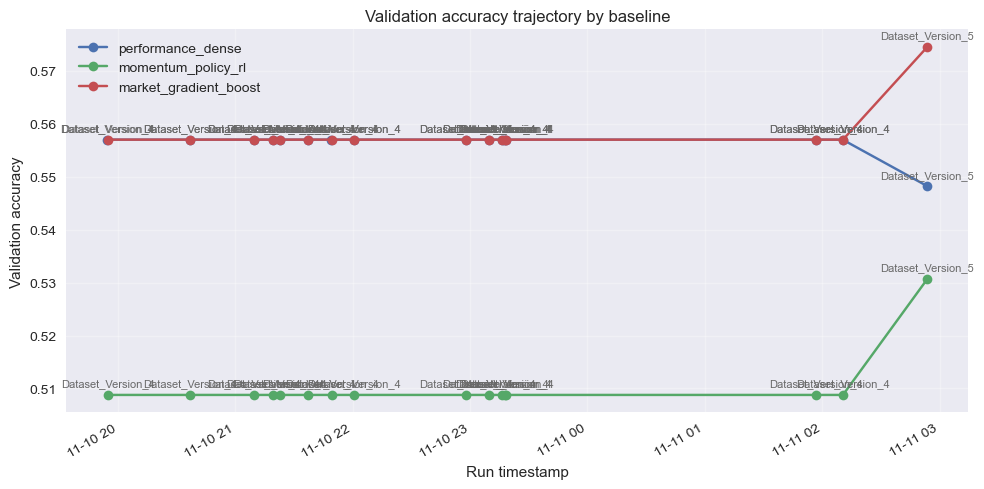

Saved validation accuracy history plot to artifacts/experiments/run_20251111-025329/validation_accuracy_history.png


In [23]:
# Historical comparison versus prior runs
if RUN_LOG_PATH.exists():
    history_df = load_run_log(RUN_LOG_PATH)
    existing_run_ids = {
        p.name.replace("run_", "")
        for p in EXPERIMENT_ROOT.glob("run_*")
        if p.is_dir()
    }
    if existing_run_ids:
        history_df = history_df[history_df["run_id"].isin(existing_run_ids)].copy()
    else:
        history_df = history_df.iloc[0:0]
    history_df["timestamp"] = pd.to_datetime(history_df["timestamp"], errors="coerce")
    history_df.sort_values("timestamp", inplace=True)

    if history_df.empty:
        print("No completed runs with artefacts found. Generate a new run and rerun this cell.")
    else:
        unlabeled_mask = history_df["dataset_label"].astype(str).str.strip() == ""
        unlabeled_df = history_df[unlabeled_mask]

        if not unlabeled_df.empty:
            print("Some historical runs are missing dataset labels. Provide a label for each data point below and click 'Apply labels', then rerun this cell to render the chart.")
            label_inputs = {}
            widgets_list = []
            for row_index, row in unlabeled_df.iterrows():
                default_value = DATASET_LABEL or ""
                descriptor = f"{row['baseline']} — {row['run_id']}"
                text_widget = widgets.Text(
                    value=default_value,
                    description=descriptor,
                    placeholder="Enter dataset name",
                    layout=widgets.Layout(width="70%"),
                )
                label_inputs[row_index] = text_widget
                widgets_list.append(text_widget)

            apply_button = widgets.Button(description="Apply labels", button_style="primary")
            status_html = widgets.HTML()

            def _apply_labels(_):
                for row_index, widget_box in label_inputs.items():
                    history_df.at[row_index, "dataset_label"] = widget_box.value.strip()
                history_df[RUN_LOG_COLUMNS].to_csv(RUN_LOG_PATH, index=False)
                status_html.value = "<span style='color:green;'>Dataset labels saved. Rerun this cell to update the comparison chart.</span>"

            apply_button.on_click(_apply_labels)
            display(widgets.VBox(widgets_list + [apply_button, status_html]))
        else:
            latest_df = history_df[history_df["run_id"] == RUN_ID]
            best_df = history_df.sort_values("val_accuracy", ascending=False).drop_duplicates("baseline")
            comparison = latest_df.merge(
                best_df[["baseline", "val_accuracy", "test_accuracy", "run_id", "dataset_label"]],
                on="baseline",
                suffixes=("_current", "_best"),
            )

            print("Most recent run vs historical best (by validation accuracy):")
            if not comparison.empty:
                display(comparison[[
                    "baseline",
                    "dataset_label_current",
                    "dataset_label_best",
                    "val_accuracy_current",
                    "val_accuracy_best",
                    "test_accuracy_current",
                    "test_accuracy_best",
                    "run_id_best",
                ]])
            else:
                print("No runs for the current run ID yet.")

            fig, ax = plt.subplots(figsize=(10, 5))
            for baseline in history_df["baseline"].unique():
                subset = history_df[history_df["baseline"] == baseline].dropna(subset=["timestamp"])
                if subset.empty:
                    continue
                ax.plot(subset["timestamp"], subset["val_accuracy"], marker="o", label=baseline)
                for row in subset.itertuples():
                    label_text = getattr(row, "dataset_label", "").strip()
                    if label_text:
                        ax.annotate(
                            label_text,
                            (row.timestamp, row.val_accuracy),
                            textcoords="offset points",
                            xytext=(0, 6),
                            ha="center",
                            fontsize=8,
                            color="dimgray",
                        )
            ax.set_title("Validation accuracy trajectory by baseline")
            ax.set_ylabel("Validation accuracy")
            ax.set_xlabel("Run timestamp")
            ax.grid(True, alpha=0.3)
            ax.legend()
            fig.autofmt_xdate()
            fig.tight_layout()
            plot_path = MODEL_ARTIFACT_DIR / "validation_accuracy_history.png"
            fig.savefig(plot_path, dpi=160)
            plt.show()
            print(f"Saved validation accuracy history plot to {plot_path}")
else:
    print("Run history file not found — this will be created after the first successful training run.")



## Attribution Diagnostics — Confusion Matrices
Persisted predictions let us visualise confusion matrices per baseline and feed future Shapley/LOO notebooks.

/var/folders/39/nf9g0crj6g99p4qm4ksg2hk40000gn/T/ipykernel_42015/1362711666.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


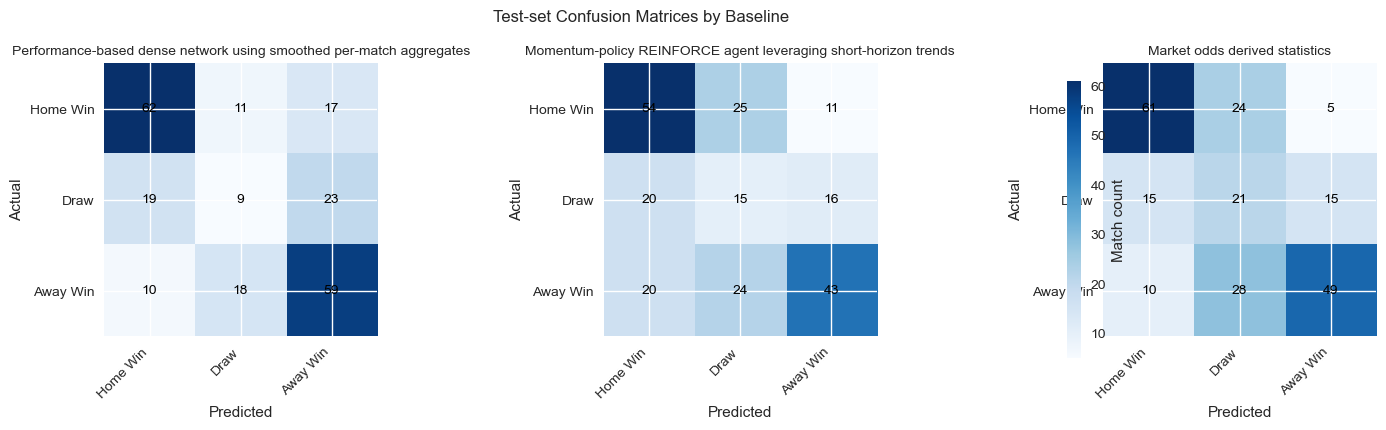

In [24]:
# Visualise confusion matrices for the latest run artefacts

def resolve_run_dir() -> Path:
    if "MODEL_ARTIFACT_DIR" in globals() and MODEL_ARTIFACT_DIR.exists():
        return MODEL_ARTIFACT_DIR
    candidates = [p for p in EXPERIMENT_ROOT.glob("run_*") if p.is_dir()]
    if not candidates:
        raise FileNotFoundError("No experiment runs found under EXPERIMENT_ROOT.")
    return max(candidates, key=lambda p: p.stat().st_mtime)

run_dir = resolve_run_dir()
num_classes = len(CLASS_LABELS)
fig, axes = plt.subplots(1, len(FEATURE_SETS), figsize=(5 * len(FEATURE_SETS), 4), squeeze=False)

for ax, (baseline_name, spec) in zip(axes.flat, FEATURE_SETS.items()):
    pred_path = run_dir / baseline_name / "test_predictions.csv"
    if not pred_path.exists():
        raise FileNotFoundError(f"Missing predictions at {pred_path}. Run the training cell first.")
    eval_df = pd.read_csv(pred_path)
    cm = tf.math.confusion_matrix(
        eval_df["target"].to_numpy(),
        eval_df["predicted"].to_numpy(),
        num_classes=num_classes,
    ).numpy()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(spec["description"], fontsize=10)
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(CLASS_LABELS, rotation=45, ha="right")
    ax.set_yticklabels(CLASS_LABELS)
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, label="Match count")
fig.suptitle("Test-set Confusion Matrices by Baseline", y=1.02)
fig.tight_layout()
plt.show()

## Next Steps
- Enrich the financial and market feature joins described in `README.md` while preserving the shared TF pipelines.
- Run attribution notebooks (KernelSHAP or batched LOO) against the saved artefacts to quantify per-signal impact.
- Automate Kaggle run summaries by extending `baseline_run_history.csv` with hyper-parameter and dataset version notes.
- Explore lightweight ensembling or calibration layers while keeping backwards-compatible metrics for longitudinal tracking.